In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=350):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))   # C*exp(i/D)
        pe[:, 0::2] = torch.sin(position * div_term)    # every even term
        pe[:, 1::2] = torch.cos(position * div_term)    # every odd term
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class CTCTransformerEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, output_size=27, dropout=0.1, nhead=8, dim_feedforward=2048):
        super(CTCTransformerEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.input_projection = nn.Linear(input_size, hidden_size)  # Project input to transformer's hidden size
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)

        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(p=dropout)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, mask = None):
        """
        :param x: (batch_size, seq_len, input_size)
        :param mask: (batch_size, seq_len)
        :return logits: (batch_size, seq_len, output_size)
        """
        x = self.input_projection(x)  # Project input
        x = self.pos_encoder(x) # add positional encodings.

        transformer_output = self.transformer_encoder(x, src_key_padding_mask = mask)  # Transformer encoder

        transformer_output = self.layer_norm(transformer_output)
        transformer_output = self.drop(transformer_output)

        logits = self.fc(transformer_output)  # Linear layer
        return F.log_softmax(logits, dim=-1)  # Log-softmax for CTC loss

In [1]:
from custom_torch_dataset import SwipeDataset
import os
from torch.utils.data import random_split

dataset_path = os.path.join(os.getcwd(), "dataset")

data = SwipeDataset(data_dir=dataset_path,
                    batch=False)

train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])

In [143]:
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def collate_fn(batch):
    """
    :param batch: List of tuples (input, word, word_tensor)
                    - input: (T, 6)
                    - word: a string of characters
                    - word_tensor: encoded word as indicies with 0 as the blank
    """
    # Sort batch by sequence length (descending order)
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)

    inputs, words, targets = zip(*batch)
    
    input_lengths = torch.LongTensor([x.shape[0] for x in inputs])  # store the lengths of inputs

    # Pad each input to a maximum length of 350 *before* pad_sequence.
    padded_inputs = [F.pad(x, (0, 0, 0, 350 - x.shape[0])) for x in inputs]

    input = torch.stack(padded_inputs, dim=0)

    target_lengths = torch.LongTensor([len(x) for x in words])
    targets = torch.cat(targets)  # concatenate all the targets

    # print(input_lengths.size())

    return input, targets, input_lengths, target_lengths, words

In [144]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)

dataloaders = {"train": train_loader,
               "val": val_loader}

In [137]:
next(iter(train_loader))

torch.Size([128])


(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.1900e+02,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.3100e+02,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.9000e+01,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  5.9000e+01,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e

In [109]:
what = (torch.arange(350).unsqueeze(1) < next(iter(train_loader))[2].unsqueeze(0)).transpose(0,1).to(device)

In [107]:
t_model = CTCTransformerEncoder(input_size=6,hidden_size=64, num_layers=2, output_size=27, dropout=0.1, nhead=4, dim_feedforward=1024).to(device)

In [110]:
t_out = t_model(next(iter(train_loader))[0].to(device), what)

In [149]:
import torch
import time
from tempfile import TemporaryDirectory
import os
import matplotlib.pyplot as plt

class EarlyStopper:
    def __init__(self, patience=15, min_delta=0.05):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            return False  # No early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False

def CTCtrain(model, dataloaders, set_lengths, optimiser, num_epochs = 5, scheduler = None, patience = 15, min_delta = 0.05):
    criterion = torch.nn.CTCLoss(blank=0, zero_infinity=True)

    train_loss = []
    val_loss = []

    early_stopper = EarlyStopper(patience=patience, min_delta = min_delta)
    stop = False

    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        lowest_loss = float("Inf")
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, targets, input_lengths, target_lengths, words in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    input_lengths = input_lengths.to(device)
                    target_lengths = target_lengths.to(device)
                    
                    mask = (torch.arange(350).unsqueeze(1).to(device) < input_lengths.unsqueeze(0)).transpose(0,1).to(device)
                    
                    # zero the parameter gradients
                    optimiser.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs, mask)
                        outputs = outputs.permute(1, 0, 2)
                        loss = criterion(outputs, targets, input_lengths, target_lengths)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
                            loss.backward()
                            optimiser.step()

                    # statistics
                    running_loss += loss.item() * len(target_lengths)  # multiply by batch size
                if phase == 'train' and scheduler is not None:
                    scheduler.step(loss)

                epoch_loss = running_loss / set_lengths[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')
                
                if phase == "train":
                    train_loss.append(epoch_loss)
                else:
                    val_loss.append(epoch_loss)
                
                # early stop based on validation loss
                if phase == 'val':
                    stop = early_stopper.early_stop(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_loss < lowest_loss:
                    lowest_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)
                
            if stop:
                break
            
            time_elapsed = time.time() - since
            print(f"Time Elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Lowest Loss: {lowest_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        plt.plot(train_loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.legend()
        plt.show
    return model

Epoch 1/100
----------
train Loss: 5.5694
val Loss: 3.2787
Time Elapsed: 0m 34s

Epoch 2/100
----------
train Loss: 3.2539
val Loss: 3.2305
Time Elapsed: 1m 8s

Epoch 3/100
----------
train Loss: 3.2226
val Loss: 3.2273
Time Elapsed: 1m 41s

Epoch 4/100
----------
train Loss: 3.2079
val Loss: 3.2183
Time Elapsed: 2m 10s

Epoch 5/100
----------
train Loss: 3.2016
val Loss: 3.1999
Time Elapsed: 2m 42s

Epoch 6/100
----------
train Loss: 3.1940
val Loss: 3.2065
Time Elapsed: 3m 14s

Epoch 7/100
----------
train Loss: 3.1857
val Loss: 3.1949
Time Elapsed: 3m 45s

Epoch 8/100
----------
train Loss: 3.1789
val Loss: 3.1726
Time Elapsed: 4m 11s

Epoch 9/100
----------
train Loss: 3.1364
val Loss: 3.1543
Time Elapsed: 4m 37s

Epoch 10/100
----------
train Loss: 3.1174
val Loss: 3.1547
Time Elapsed: 5m 3s

Epoch 11/100
----------
train Loss: 3.1057
val Loss: 3.1174
Time Elapsed: 5m 28s

Epoch 12/100
----------
train Loss: 3.0926
val Loss: 3.0751
Time Elapsed: 5m 54s

Epoch 13/100
----------
tra

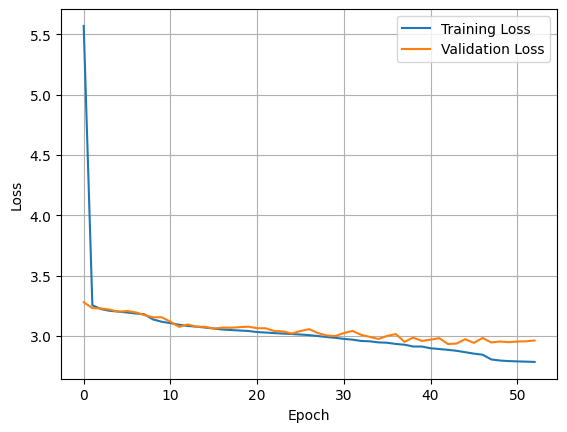

In [155]:
t_model = CTCTransformerEncoder(input_size=6,hidden_size=128, num_layers=2, output_size=27, dropout=0.1, nhead=4, dim_feedforward=256).to(device)

set_lengths = {"train":len(train_set),
               "val":len(val_set)}
optimiser = torch.optim.AdamW(t_model.parameters(), lr=0.001)
# optimiser = torch.optim.SGD(c_model.parameters(), lr=0.01, momentum=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.1)
c_model = CTCtrain(t_model, dataloaders,set_lengths, optimiser, num_epochs=100, scheduler=scheduler, patience = 10, min_delta = 0.01)